In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import contextily as ctx
from torch.optim.lr_scheduler import ReduceLROnPlateau
import plotly.graph_objs as go

In [2]:
X_train, y_train = torch.load('train_data.pt')
X_test, y_test = torch.load('test_data.pt')

In [3]:
X_train.head()

,speed,direction,altitude,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,lon,lat
1429,"[0.9051045791951539, 0.36488358527490866, 1.08...","[213.59247189761314, 50.80250216324066, 183.13...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0256121158599854, 1.0256121158599854, 1.025...","[0.3663296103477478, 0.3663296103477478, 0.366...","[0.5513201951980591, 0.5513201951980591, 0.551...","[0.07311602681875229, 0.07311602681875229, 0.0...","[-0.8946580290794373, -0.8946580290794373, -0....","[-0.2698259651660919, -0.2698259651660919, -0....","[-0.2163011133670807, -0.2163011133670807, -0....","[0.7204081416130066, 0.7204081416130066, 0.720...","[-0.02065705507993698, -0.02065705507993698, -...","[-0.9212825894355774, -0.9212825894355774, -0....","[116.3014351480511, 116.30150542563571, 116.30...","[39.96877567574513, 39.96878432818993, 39.9686..."
67,"[3.0108908393211498, 3.0108908393211498, 6.122...","[288.5357135551421, 322.5141456425275, 357.111...","[124.671916010499, 124.671916010499, 124.67191...","[0.46460089087486267, 0.46460089087486267, 0.6...","[0.1521492749452591, 0.1521492749452591, 0.346...","[0.540621280670166, 0.540621280670166, 0.62186...","[0.1624462604522705, 0.1624462604522705, 0.175...","[-0.4449816346168518, -0.4449816346168518, -0....","[-0.14718317985534668, -0.14718317985534668, -...","[-0.07059749215841293, -0.07059749215841293, -...","[0.5213332176208496, 0.5213332176208496, 0.588...","[-0.09077417105436325, -0.09077417105436325, -...","[-0.5483834147453308, -0.5483834147453308, -0....","[116.44731858033349, 116.44676390819669, 116.4...","[39.92016651131108, 39.92061223955805, 39.9216..."
1703,"[18.850246964938353, 23.816038343712744, 18.26...","[335.4858884561994, 329.48940661299076, 332.93...","[133.0, 122.0, 122.0, 116.0, 96.0, 100.0, 108....","[0.5349023342132568, 0.17976602911949158, 0.17...","[-0.6651846170425415, -0.42298227548599243, -0...","[0.12552687525749207, 0.1509539932012558, 0.15...","[-0.7920409440994263, -0.523102879524231, -0.5...","[-0.0477927140891552, 0.21758998930454254, 0.2...","[-0.5892762541770935, -0.2122603952884674, -0....","[0.8264040946960449, 0.6603919267654419, 0.660...","[0.2962551712989807, 0.07370658218860626, 0.07...","[0.112643763422966, 0.001559823751449585, 0.00...","[0.5791710615158081, 0.5857739448547363, 0.585...","[116.32082929368482, 116.31593850769198, 116.3...","[40.05726168456284, 40.06362562880345, 40.0664..."
3816,"[9.795189633300517, 9.795189633300517, 16.3215...","[262.22607388023835, 266.33142518408016, 215.0...","[492.0, 486.0, 134.0, 157.0, 154.0, 155.0, 153...","[0.8499414920806885, 0.8499414920806885, 0.849...","[0.020452499389648438, 0.020452499389648438, 0...","[0.30733856558799744, 0.30733856558799744, 0.3...","[-0.10952486097812653, -0.10952486097812653, -...","[-0.7700713872909546, -0.7700713872909546, -0....","[-0.33048173785209656, -0.33048173785209656, -...","[0.04297511279582977, 0.04297511279582977, 0.0...","[0.5876412987709045, 0.5876412987709045, 0.587...","[0.03853924944996834, 0.03853924944996834, 0.0...","[-0.5446991920471191, -0.5446991920471191, -0....","[116.35840071808049, 116.35726092090769, 116.3...","[39.98660396412316, 39.98634070857769, 39.9861..."
221,"[1.4790322663962254, 0.8986250414306074, 0.301...","[44.764987305878094, 111.28007895606697, 113.5...","[115.0, 158.0, 132.0, 134.0, 140.0, 140.0, 134...","[0.8768018484115601, 0.8768018484115601, 0.876...","[-0.234211266040802, -0.234211266040802, -0.23...","[0.43553626537323, 0.43553626537323, 0.4355362...","[-0.04397360235452652, -0.04397360235452652, -...","[-0.7363857626914978, -0.7363857626914978, -0....","[-0.3531106412410736, -0.3531106412410736, -0....","[0.2993607223033905, 0.2993607223033905, 0.299...","[0.7298173904418945, 0.7298173904418945, 0.729...","[0.03381585702300072, 0.03381585702300072, 0.0...","[-0.3639601469039917, -0.3639601469039917, -0....","[116.42498845860966, 116.4256920976405, 116.42...","[39.9670260052923, 39.9666455530600

In [21]:
def plot_trajectories(trajectories):
    if isinstance(trajectories[0], LineString):
        trajectories = [list(trajectory.coords) for trajectory in trajectories]

    fig = go.Figure()
    for trajectory in trajectories:
        lon = [point[0] for point in trajectory]
        lat = [point[1] for point in trajectory]

        fig.add_trace(go.Scattermapbox(
            mode="markers+lines",
            lon=lon,
            lat=lat,
            marker={'size': 10}
        ))

    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_zoom=10,
        margin={"r": 0, "t": 0, "l": 0, "b": 0}
    )

    fig.show()

In [29]:
i = 3
g = [list(zip(X_train.iloc[i, 13], X_train.iloc[i, 14]))]

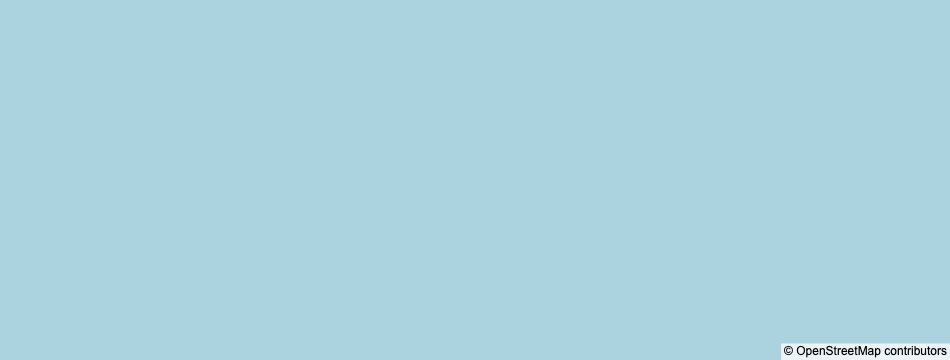

In [30]:
plot_trajectories(g)

In [37]:
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_seq = self.X.iloc[idx].values
        y_val = self.y.iloc[idx]
        
        X_tensor = torch.tensor([item for item in X_seq], dtype=torch.float32)
        y_tensor = torch.tensor(y_val, dtype=torch.float32)
        
        return X_tensor, y_tensor

In [38]:
train_dataset = SequenceDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = SequenceDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [39]:
class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(TrajectoryLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

/var/folders/06/3kkbb_xs2lv1lyxjjvq855fh0000gn/T/ipykernel_1161/716397446.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  len(X_train.iloc[0][0])


30

In [42]:
# Hyperparameters
input_size = len(X_train.iloc[0][0])
hidden_size = 128  # Rozmiar warstwy ukrytej
num_layers = 8 # Liczba warstw LSTM
output_size = 2  # Liczba wyjść (lon, lat)
num_epochs = 5
learning_rate = 0.001

# Inicjalizacja modelu, funkcji straty i optymalizatora
model = TrajectoryLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

# Przeniesienie modelu na GPU, jeśli jest dostępny
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/var/folders/06/3kkbb_xs2lv1lyxjjvq855fh0000gn/T/ipykernel_1161/273141821.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input_size = len(X_train.iloc[0][0])
/Users/szymonleszkiewicz/anaconda3/envs/obsrai/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


TrajectoryLSTM(
  (lstm): LSTM(30, 128, num_layers=8, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [43]:
train_losses = []
val_losses = []

# Pętla trenowania
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    scheduler.step(train_loss)

    # Walidacja po każdej epoce
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets.float())
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    # print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch [1/5], Step [100/103], Loss: 330705.8438
Epoch [2/5], Step [100/103], Loss: 241399.7344
Epoch [3/5], Step [100/103], Loss: 176383.7969
Epoch [4/5], Step [100/103], Loss: 127882.5234
Epoch [5/5], Step [100/103], Loss: 91605.2812


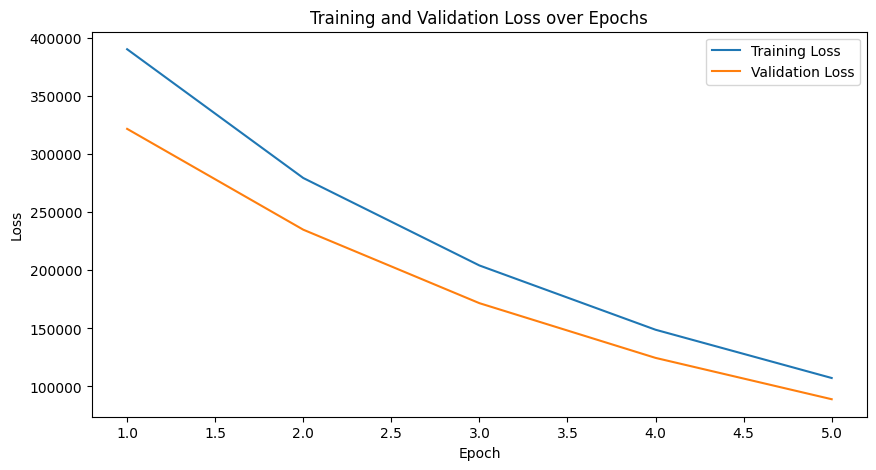

In [44]:
# Wizualizacja strat
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [21]:
preds = []
trues = []
for inputs, targets in test_loader:
    inputs = inputs.to(device)
    targets = targets.to(device)

    outputs = model(inputs)
    for i in range(10):
        print(f'Pred: {outputs[i].detach().cpu().numpy()}, True: {targets[i].detach().cpu().numpy()}')
    preds.append(outputs.detach().cpu().numpy())
    trues.append(targets.detach().cpu().numpy())

Pred: [116.35684  39.94516], True: [116.41591   39.967762]
Pred: [116.35684  39.94516], True: [116.34631   39.984364]
Pred: [116.35684  39.94516], True: [116.32904  39.97823]
Pred: [116.35684  39.94516], True: [116.406815  40.06634 ]
Pred: [116.35684  39.94516], True: [116.3313   39.97726]
Pred: [116.35684  39.94516], True: [116.318115  39.998764]
Pred: [116.35684  39.94516], True: [116.31164   40.036076]
Pred: [116.35684  39.94516], True: [116.34284  39.98492]
Pred: [116.35684  39.94516], True: [116.29477   39.973686]
Pred: [116.35684  39.94516], True: [116.29915  39.97167]
Pred: [116.35684  39.94516], True: [116.33039   39.976517]
Pred: [116.35684  39.94516], True: [116.34231   39.974846]
Pred: [116.35684  39.94516], True: [116.30331  40.03479]
Pred: [116.35684  39.94516], True: [116.30118  40.05081]
Pred: [116.35684  39.94516], True: [116.40586  40.04232]
Pred: [116.35684  39.94516], True: [116.29252  39.98974]
Pred: [116.35684  39.94516], True: [117.15986  40.16559]
Pred: [116.3568

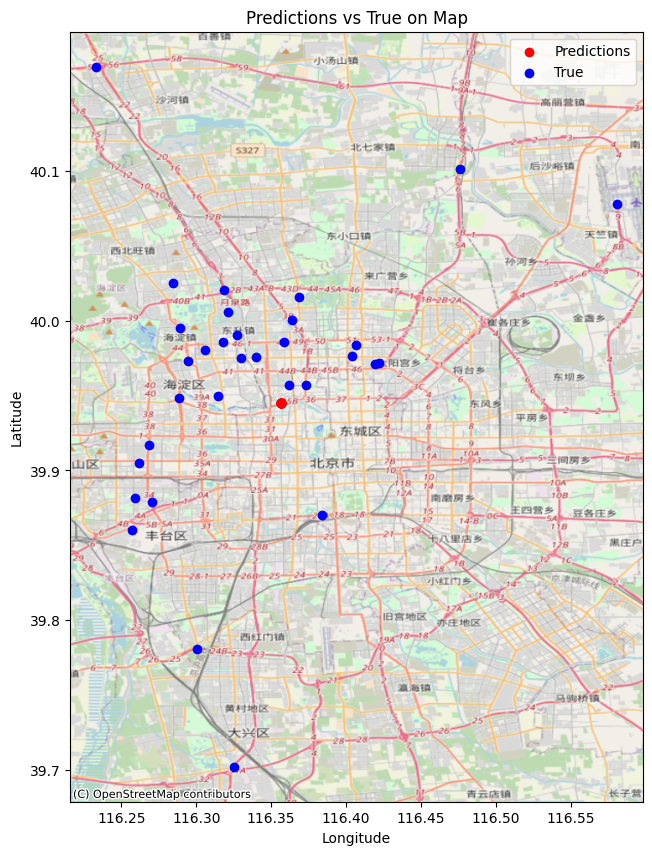

In [20]:
# Flattening preds and trues to the correct shape
preds = np.array(preds).reshape(-1, 2)
trues = np.array(trues).reshape(-1, 2)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot predictions and true values
ax.scatter(preds[:, 0], preds[:, 1], color='red', label='Predictions')
ax.scatter(trues[:, 0], trues[:, 1], color='blue', label='True')

# Adding a basemap from contextily
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

# Setting labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Predictions vs True on Map')
ax.legend()

# Show the plot
plt.show()

# EXP 2

In [153]:
# Hyperparameters
input_size = 200
hidden_size = 128  # Rozmiar warstwy ukrytej
num_layers = 2  # Liczba warstw LSTM
output_size = 2  # Liczba wyjść (lon, lat)
num_epochs = 15
learning_rate = 0.001

# Inicjalizacja modelu, funkcji straty i optymalizatora
model = TrajectoryLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Przeniesienie modelu na GPU, jeśli jest dostępny
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


TrajectoryLSTM(
  (lstm): LSTM(200, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [154]:
train_losses = []
val_losses = []

# Pętla trenowania
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Walidacja po każdej epoce
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets.float())
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    # print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch [1/15], Step [100/270], Loss: 60.7389
Epoch [1/15], Step [200/270], Loss: 47.1001
Epoch [2/15], Step [100/270], Loss: 31.7357
Epoch [2/15], Step [200/270], Loss: 25.1294
Epoch [3/15], Step [100/270], Loss: 14.0775
Epoch [3/15], Step [200/270], Loss: 7.5841
Epoch [4/15], Step [100/270], Loss: 0.0483
Epoch [4/15], Step [200/270], Loss: 0.0987
Epoch [5/15], Step [100/270], Loss: 0.0644
Epoch [5/15], Step [200/270], Loss: 0.0759
Epoch [6/15], Step [100/270], Loss: 0.0775
Epoch [6/15], Step [200/270], Loss: 0.0742
Epoch [7/15], Step [100/270], Loss: 0.0816
Epoch [7/15], Step [200/270], Loss: 0.0909
Epoch [8/15], Step [100/270], Loss: 0.0883
Epoch [8/15], Step [200/270], Loss: 0.0916
Epoch [9/15], Step [100/270], Loss: 0.0847
Epoch [9/15], Step [200/270], Loss: 0.0744
Epoch [10/15], Step [100/270], Loss: 0.0880
Epoch [10/15], Step [200/270], Loss: 0.0735
Epoch [11/15], Step [100/270], Loss: 0.0908
Epoch [11/15], Step [200/270], Loss: 0.0658
Epoch [12/15], Step [100/270], Loss: 0.0868
E

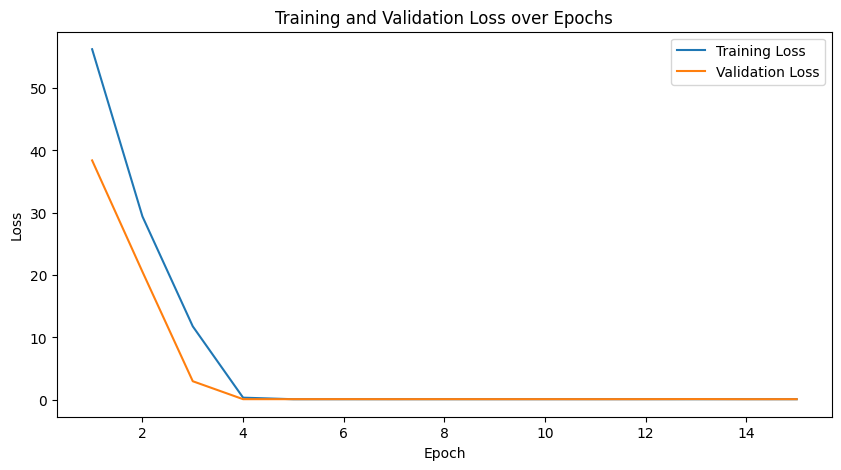

In [155]:
# Wizualizacja strat
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [207]:
preds = []
trues = []
for inputs, targets in test_loader:
    inputs = inputs.to(device)
    targets = targets.to(device)

    outputs = model(inputs)
    for i in range(10):
        print(f'Pred: {outputs[i].detach().cpu().numpy()}, True: {targets[i].detach().cpu().numpy()}')
    preds.append(outputs.detach().cpu().numpy())
    trues.append(targets.detach().cpu().numpy())
    break

RuntimeError: mat1 and mat2 shapes cannot be multiplied (480x256 and 192x64)

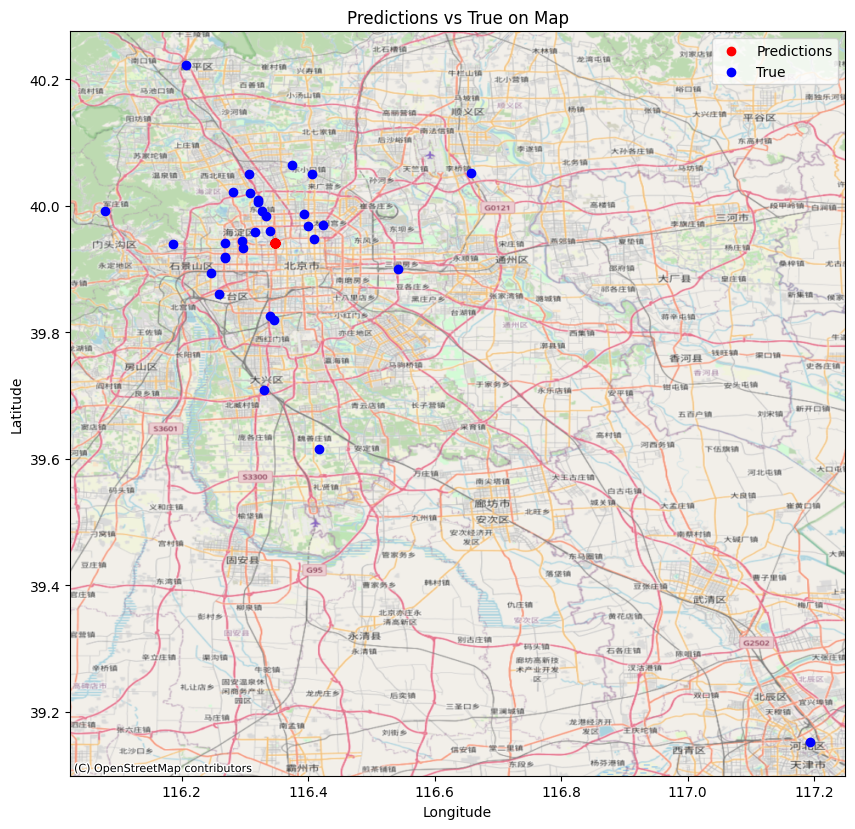

In [158]:
# Flattening preds and trues to the correct shape
preds = np.array(preds).reshape(-1, 2)
trues = np.array(trues).reshape(-1, 2)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot predictions and true values
ax.scatter(preds[:, 0], preds[:, 1], color='red', label='Predictions')
ax.scatter(trues[:, 0], trues[:, 1], color='blue', label='True')

# Adding a basemap from contextily
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

# Setting labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Predictions vs True on Map')
ax.legend()

# Show the plot
plt.show()


# NNPred

In [206]:
class NNPred(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=64, batch_size=32, dropout=0.05):
        super(NNPred, self).__init__()

        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layers = 2

        self.in2lstm = nn.Linear(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=self.num_layers, bidirectional=False, batch_first=True, dropout=dropout)
        self.in2bilstm = nn.Linear(input_size, hidden_size)
        self.bilstm = nn.LSTM(hidden_size, hidden_size//2, num_layers=self.num_layers, bidirectional=True, batch_first=True, dropout=dropout)

        self.fc0 = nn.Linear(hidden_size, 128)  # Redukcja liczby cech w bilstm_out
        self.fc1 = nn.Linear(128 + hidden_size//2, 64)  # Dodanie redukowanego bilstm_out do lstm_out
        self.fc2 = nn.Linear(64, output_size)
        self.in2out = nn.Linear(input_size, 64)
        self.tanh = nn.Tanh()

    def forward(self, input):
        bilstm_out, _ = self.bilstm(self.in2bilstm(input))
        lstm_out, _ = self.lstm(self.in2lstm(input))

        # Redukcja liczby cech w bilstm_out
        bilstm_out_reduced = self.fc0(bilstm_out)

        # Redukcja liczby cech w lstm_out
        lstm_out_reduced = lstm_out[:, :, :hidden_size//2]  # Wybierz pierwsze 128 cech z lstm_out

        out = self.tanh(torch.cat((lstm_out_reduced, bilstm_out_reduced), dim=-1))
        out = self.tanh(self.fc1(out))
        out = out + self.in2out(input)
        output = self.fc2(out)  # zakres [0, 1]
        return output

In [204]:
# Hyperparameters
input_size = 200
hidden_size = 128  # Rozmiar warstwy ukrytej
num_layers = 2  # Liczba warstw LSTM
output_size = 2  # Liczba wyjść (lon, lat)
num_epochs = 15
learning_rate = 0.001

# Inicjalizacja modelu, funkcji straty i optymalizatora
model = NNPred(input_size, output_size,hidden_size,32)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Przeniesienie modelu na GPU, jeśli jest dostępny
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

NNPred(
  (in2lstm): Linear(in_features=200, out_features=128, bias=True)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.05)
  (in2bilstm): Linear(in_features=200, out_features=128, bias=True)
  (bilstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.05, bidirectional=True)
  (fc0): Linear(in_features=128, out_features=128, bias=True)
  (fc1): Linear(in_features=192, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (in2out): Linear(in_features=200, out_features=64, bias=True)
  (tanh): Tanh()
)

In [205]:

train_losses = []
val_losses = []

# Pętla trenowania
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Walidacja po każdej epoce
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets.float())
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    # print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (480x256 and 192x64)